## Twitter Sentiment Analysis

### Project Overview

An important aspect of human understanding is investigating not only the what and why behind actions, but also how people might feel about toward a certain suject. In literature, those who read closely will pay attention not only to the plot but also how the author or characters might feel about a subject. Following this example, literary analysts dedicate time and care to understanding the speaker's tone. Today, it is extremely powerful to facilitate this same process at scale. Sentiment analysis is the process of tying emotions to data. This project will use twitter data and classify the messages into positive or negative "emotion" categories.  

### Problem Statement

This project seeks to classify a user's sentiment into positive or negative emotion categories. The general strategy is to pull twitter sample tweets that have been prelabeled as positive or negative. The data will be divide the data into test and train sets. The model will be trained on a multinomial naive bayes model. 

### Metrics

The model will be evaluated by using the models .score() method which returns the mean accuracy on given test data and labels. 

In [164]:
import tweepy as tw
import pandas as pd
import nltk
from nltk.corpus import twitter_samples, stopwords
from nltk.tag import pos_tag
import re, string, random
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import FreqDist, classify, NaiveBayesClassifier
from nltk.tokenize import word_tokenize
import itertools
import numpy as np
from sklearn.model_selection import train_test_split
from collections import Counter 
import matplotlib.pyplot as plt; plt.rcdefaults()
import matplotlib.pyplot as plt

In [ ]:
#get sample tweets (use for training data)
nltk.download('twitter_samples')
nltk.download('stopwords')
nltk.download('punkt')

### Data Exploration

In [165]:
#downloading nltk datasets to train the model - this is already labeled as positive 
positive_tweets = twitter_samples.strings('positive_tweets.json')
negative_tweets = twitter_samples.strings('negative_tweets.json')

In [229]:
#example of positive and negative tweet
positive_tweets[0:10],negative_tweets[0:10]

(['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
  '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
  '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
  '@97sides CONGRATS :)',
  'yeaaaah yippppy!!!  my accnt verified rqst has succeed got a blue tick mark on my fb profile :) in 15 days',
  '@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
  "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI",
  '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
  'Jgh , but we have to go to Bayan :D bye',
  'As an act of mischievousness, am calling the ETL layer of our in-house wa

In [167]:
#5000 prelabled positive tweets and negative tweets each so the data is evenly distributed
len(positive_tweets), len(negative_tweets)

(5000, 5000)

In [168]:
#urls make the data noisy
[tweet for tweet in positive_tweets if (tweet.find('http') > -1)]

['@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
 "We don't like to keep our lovely customers waiting for long! We hope you enjoy! Happy Friday! - LWWF :) https://t.co/smyYriipxI",
 "Who Wouldn't Love These Big....Juicy....Selfies :) - http://t.co/QVzjgd1uFo http://t.co/oWBL11eQRY",
 '@Mish23615351  follow @jnlazts &amp; http://t.co/RCvcYYO0Iq follow u back :)',
 'Great new opportunity for junior triathletes aged 12 and 13 at the Gatorade series! Get your entries in :) http://t.co/of3DyOzML0',
 'Hello I need to know something can u fm me on Twitter?? — sure thing :) dm me x http://t.co/W6Dy130BV7',
 'Spiritual Ritual Festival (Népal)\nBeginning of Line-up :)\nIt is left for the line-up (y)\nSee more at:... http://t.co/QMNz62OEuc',
 'MY kik - hatessuce32429 #kik #kikme #lgbt #tinder #nsfw #akua #cumshot :) http://t.co/TnHJD36yzf',
 '@jamiefigsxx  follow @jnlazts &amp; http://t.co/RCvcYYO0Iq follow u back :)',
 'I added a video 

In [169]:
#@ signs make the data noisy
[tweet for tweet in positive_tweets if (tweet.find('@') > -1)]

['#FollowFriday @France_Inte @PKuchly57 @Milipol_Paris for being top engaged members in my community this week :)',
 '@Lamb2ja Hey James! How odd :/ Please call our Contact Centre on 02392441234 and we will be able to assist you :) Many thanks!',
 '@DespiteOfficial we had a listen last night :) As You Bleed is an amazing track. When are you in Scotland?!',
 '@97sides CONGRATS :)',
 '@BhaktisBanter @PallaviRuhail This one is irresistible :)\n#FlipkartFashionFriday http://t.co/EbZ0L2VENM',
 '@Impatientraider On second thought, there’s just not enough time for a DD :) But new shorts entering system. Sheep must be buying.',
 '#FollowFriday @wncer1 @Defense_gouv for being top influencers in my community this week :)',
 '@Mish23615351  follow @jnlazts &amp; http://t.co/RCvcYYO0Iq follow u back :)',
 "@jjulieredburn Perfect, so you already know what's waiting for you :)",
 "@RookieSenpai @arcadester it is the id conflict thanks for the help :D here's the screenshot of it working",
 '@oohdawg_

In [170]:
#so me think why waste time say lot word when few word do trick
#There are 179 stop words that do not impact the sentiment of text
stop_words = stopwords.words('english')
len(stop_words),stop_words

(179,
 ['i',
  'me',
  'my',
  'myself',
  'we',
  'our',
  'ours',
  'ourselves',
  'you',
  "you're",
  "you've",
  "you'll",
  "you'd",
  'your',
  'yours',
  'yourself',
  'yourselves',
  'he',
  'him',
  'his',
  'himself',
  'she',
  "she's",
  'her',
  'hers',
  'herself',
  'it',
  "it's",
  'its',
  'itself',
  'they',
  'them',
  'their',
  'theirs',
  'themselves',
  'what',
  'which',
  'who',
  'whom',
  'this',
  'that',
  "that'll",
  'these',
  'those',
  'am',
  'is',
  'are',
  'was',
  'were',
  'be',
  'been',
  'being',
  'have',
  'has',
  'had',
  'having',
  'do',
  'does',
  'did',
  'doing',
  'a',
  'an',
  'the',
  'and',
  'but',
  'if',
  'or',
  'because',
  'as',
  'until',
  'while',
  'of',
  'at',
  'by',
  'for',
  'with',
  'about',
  'against',
  'between',
  'into',
  'through',
  'during',
  'before',
  'after',
  'above',
  'below',
  'to',
  'from',
  'up',
  'down',
  'in',
  'out',
  'on',
  'off',
  'over',
  'under',
  'again',
  'further',

### Data Visualization

In [171]:
#tokenize positive and negative tweets
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

In [173]:
all_words = list(itertools.chain.from_iterable(positive_tweet_tokens)) + list(itertools.chain.from_iterable(negative_tweet_tokens))
len(all_words)

130099

In [174]:
max(set(all_words), key = all_words.count) 

':('

In [175]:
sign = []
count = []
for item in Counter(all_words).most_common(10):
    sign.append(item[0])
    count.append(item[1])
sign,count

([':(', ':)', '!', 'I', '.', 'to', 'you', 'the', ',', 'a'],
 [4586, 3693, 2675, 2477, 2433, 2133, 2001, 1845, 1698, 1515])

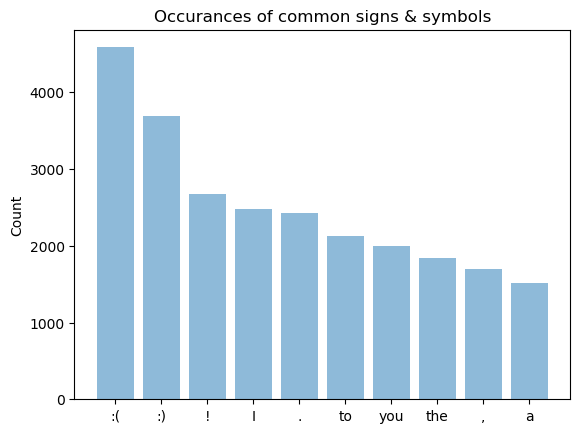

In [176]:
#Most common symbols are not words so these should be filtered down
objects = sign
y_pos = np.arange(len(objects))
performance = count

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Occurances of common signs & symbols')

plt.show()

### Data Pre Processing

In [177]:
#tokenize positive and negative tweets
positive_tweet_tokens = twitter_samples.tokenized('positive_tweets.json')
negative_tweet_tokens = twitter_samples.tokenized('negative_tweets.json')

In [178]:
#remove urls
positive_tweet_tokens = [[word for word in tweet if (word.find('http')==-1)] for tweet in positive_tweet_tokens]
negative_tweet_tokens = [[word for word in tweet if (word.find('http')==-1)] for tweet in negative_tweet_tokens]

In [179]:
#remove @
positive_tweet_tokens = [[word for word in tweet if (word.find('@')==-1)] for tweet in positive_tweet_tokens]
negative_tweet_tokens = [[word for word in tweet if (word.find('@')==-1)] for tweet in negative_tweet_tokens]

In [180]:
## remove stopwords
positive_tweet_tokens = [list(set(tweet) - set(stop_words)) for tweet in positive_tweet_tokens]
negative_tweet_tokens = [list(set(tweet) - set(stop_words)) for tweet in negative_tweet_tokens]

In [181]:
#lemmatize words
lemmatizer = WordNetLemmatizer()
positive_tweet_tokens = [[lemmatizer.lemmatize(word) for word in tweet] for tweet in positive_tweet_tokens]
negative_tweet_tokens = [[lemmatizer.lemmatize(word) for word in tweet] for tweet in negative_tweet_tokens]

80724


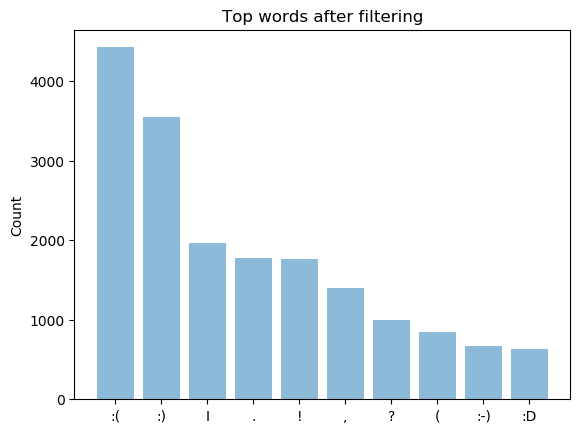

In [182]:
#filtered
#to, you, the, a, taken out
all_words = list(itertools.chain.from_iterable(positive_tweet_tokens)) + list(itertools.chain.from_iterable(negative_tweet_tokens))
print(len(all_words));

sign = []
count = []
for item in Counter(all_words).most_common(10):
    sign.append(item[0])
    count.append(item[1])
    
#Most common symbols are not words so these should be filtered down
objects = sign
y_pos = np.arange(len(objects))
performance = count

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Top words after filtering')

plt.show()

41158


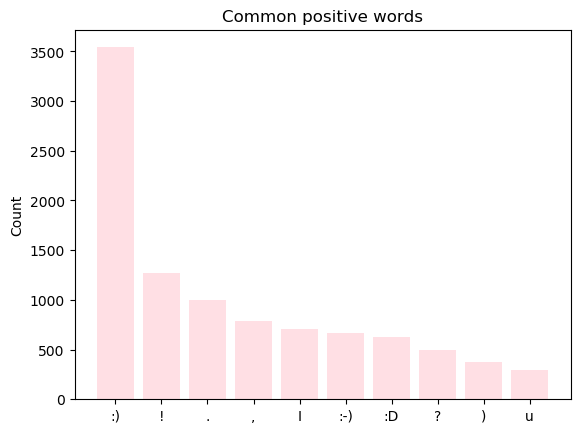

In [230]:
#positive only
pos_words = list(itertools.chain.from_iterable(positive_tweet_tokens))
print(len(pos_words));

sign = []
count = []
for item in Counter(pos_words).most_common(10):
    sign.append(item[0])
    count.append(item[1])
    
#Most common symbols are not words so these should be filtered down
objects = sign
y_pos = np.arange(len(objects))
performance = count

plt.bar(y_pos, performance, align='center', alpha=0.5,color='pink')
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Common positive words')

plt.show()

In [227]:
Counter(pos_words).most_common(50)

[(':)', 3541),
 ('!', 1269),
 ('.', 1000),
 (',', 786),
 ('I', 707),
 (':-)', 669),
 (':D', 628),
 ('?', 495),
 (')', 379),
 ('u', 298),
 ('...', 253),
 ('day', 230),
 ('love', 222),
 ('follow', 216),
 (':', 211),
 ('Thanks', 208),
 ('like', 203),
 ('-', 185),
 ('thanks', 181),
 ('&', 165),
 ('good', 158),
 ('back', 153),
 ("I'm", 153),
 ('know', 142),
 ('get', 142),
 ('Hi', 141),
 ('great', 136),
 (':p', 135),
 ('"', 131),
 ('Thank', 130),
 ('new', 125),
 ('time', 115),
 ('one', 114),
 ('thank', 112),
 ('..', 111),
 ('see', 107),
 ('Happy', 102),
 ('today', 102),
 ('You', 93),
 ('Friday', 92),
 ('Have', 89),
 ('via', 85),
 ('hope', 84),
 ('lot', 83),
 ('nice', 83),
 ('week', 82),
 ('<3', 82),
 ("I'll", 82),
 ('The', 82),
 ('much', 82)]

39566


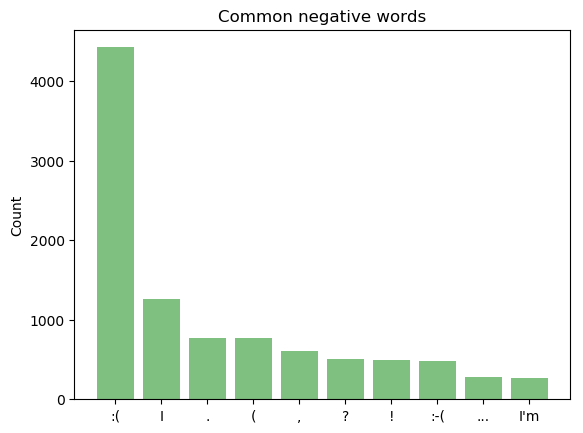

In [226]:
#negative only
neg_words = list(itertools.chain.from_iterable(negative_tweet_tokens))
print(len(neg_words));

sign = []
count = []
for item in Counter(neg_words).most_common(10):
    sign.append(item[0])
    count.append(item[1])
    
#Most common symbols are not words so these should be filtered down
objects = sign
y_pos = np.arange(len(objects))
performance = count

plt.bar(y_pos, performance, align='center', alpha=0.5,color='green')
plt.xticks(y_pos, objects)
plt.ylabel('Count')
plt.title('Common negative words')

plt.show()

In [228]:
Counter(neg_words).most_common(50)

[(':(', 4423),
 ('I', 1254),
 ('.', 771),
 ('(', 769),
 (',', 609),
 ('?', 504),
 ('!', 496),
 (':-(', 481),
 ('...', 284),
 ("I'm", 272),
 ('miss', 216),
 ('want', 198),
 ('like', 187),
 (':', 182),
 ('get', 175),
 ('u', 173),
 ("can't", 162),
 ('time', 151),
 ('day', 135),
 ('go', 132),
 ('one', 132),
 ('know', 122),
 ('please', 116),
 ('back', 112),
 ('-', 111),
 ('ME', 111),
 ('really', 109),
 ('sorry', 109),
 ('sad', 108),
 ('still', 102),
 ('feel', 101),
 ('today', 100),
 ('&', 98),
 ('"', 96),
 ('much', 96),
 ('..', 96),
 ('PLEASE', 96),
 ('work', 95),
 ('see', 95),
 ('got', 92),
 ('My', 90),
 ('need', 89),
 ('im', 88),
 ('wanna', 84),
 ('love', 82),
 ('make', 81),
 ('going', 81),
 ('sleep', 81),
 ('good', 80),
 ('wish', 80)]

In [191]:
#14707 unique words
unique_words = list(set(itertools.chain.from_iterable(positive_tweet_tokens)) | set(itertools.chain.from_iterable(negative_tweet_tokens)))
len(unique_words)

14707

### Implementation

In [192]:
#one hot encoding each word in the tweets
tweet_list = []
sentiments = np.zeros(len(positive_tweet_tokens+negative_tweet_tokens))
mid = 0
for i in range(0,len(positive_tweet_tokens)):
    tweet = positive_tweet_tokens[i]
    tweet_counts = np.zeros(len(unique_words))
    for j in range(0, len(unique_words)):
        word = unique_words[j]
        tweet_counts[j] = tweet.count(word)
    tweet_list.append(tweet_counts)
    sentiments[i] = 0 # encode 0 for positive sentiment
    mid = mid + 1
for i in range(0,len(negative_tweet_tokens)):
    tweet = negative_tweet_tokens[i]
    tweet_counts = np.zeros(len(unique_words))
    for j in range(0, len(unique_words)):
        word = unique_words[j]
        tweet_counts[j] = tweet.count(word)
    tweet_list.append(tweet_counts)
    sentiments[5000+i] = 1 #encode 1 for negative sentiment
    mid = mid + 1

In [193]:
#words one hot encoded
tweet_list

[array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 0., 0., 0.]),
 array([0., 0., 0., ..., 

In [194]:
#sentiments in the same order as the tweet list
sentiments

array([0., 0., 0., ..., 1., 1., 1.])

In [195]:
#create an array of arrays for modeling
tweets_array = np.vstack(tweet_list)
tweets_array.shape

(10000, 14707)

In [196]:
#mix up the tweets and sentiments
import random
new_order = random.sample(range(0, tweets_array.shape[0]), tweets_array.shape[0])
new_tweets = tweets_array[new_order]
new_sentiments = sentiments[new_order]

In [197]:
#there are 10000 rows for all the tweets, one hot encode for the 14K unique words
new_tweets.shape, new_sentiments.shape

((10000, 14707), (10000,))

In [198]:
#split into test and train
X_train, X_test, y_train, y_test = train_test_split(new_tweets, new_sentiments, test_size=0.33, random_state=42)

In [199]:
#multinomial naive bayes classifier
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
clf.score(X_test, y_test) #score is pretty good so far

0.996969696969697

### Refinement

In [218]:
#change alpha to 0 and fit prior to false
#challenging to refine further
#stay with initial solution
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB(alpha=0, fit_prior=False, class_prior=None)
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
clf.score(X_test, y_test) #lower score

/anaconda3/lib/python3.7/site-packages/sklearn/naive_bayes.py:485: UserWarning: alpha too small will result in numeric errors, setting alpha = 1.0e-10
  'setting alpha = %.1e' % _ALPHA_MIN)


0.8839393939393939

In [220]:
#Final solution - aka original solution
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(X_train, y_train)
preds = clf.predict(X_test)
clf.score(X_test, y_test)

0.996969696969697

### Model Evaluation and Results

In [221]:
clf.get_params()

{'alpha': 1.0, 'class_prior': None, 'fit_prior': True}

Alpha is kept as 1 because lowering the value decreases the clf score.class_prior is kept as None because there are no specified priors ahead of time. fit prior is true so that the model can determine if there are class priors or not

In [200]:
def encodeTweet(tweet_array):
    tweet_counts = np.zeros(len(unique_words))
    for j in range(0, len(unique_words)):
        word = unique_words[j]
        tweet_counts[j] = tweet_array.count(word)
    return tweet_counts

However the model is not perfect. It has a hard time detecting "sarcastic" or non traditional meanings. Here damn is used positively though the model detects it as negatively. 

In [207]:
test_tweet = 'damn you are the best'

In [208]:
from tokenize import tokenize

In [209]:
#predicted 1 for negative sentiment but this is a sort of nice thing to say 
clf.predict(encodeTweet(nltk.word_tokenize(test_tweet)).reshape(1, -1))

array([1.])

### Justification

The overall model has an accuracy score of 0.997 which is pretty good. The multinomial naive bayes model was an effective choice for a text classifier because there are many features to predict for sentiment. Keeping the default parameters had the highest accuracy. This is likely because there is no predetermined weighting for any words that is intuitive to add to the model.

### Reflection

Sentiment analysis is powerful because it allows us to see beyond what is written on a page. We can see more abstract things such as the speaker's tone toward a subject or the mood of a text. What is also important is that programmatic sentiment analysis allows us to determine how larger populations feel about a certain subject. 

In my exploration of sentiment analysis, I analyzed the sentiment of 10K tweets and used a multinomial naive bayes model to classify the tweets into positive or negative sentiments. The model was able to accurately predict 99% of the testing data sentiments which is pretty good. What is more challenging and an area for growth is determining more complex sentiments such as sarcasm.

### Improvement

This will be an ongoing project and I am looking forward to refining the model. Next steps will be to try other algorithms such as random forest. I also look forward to finding data sets that are labeled with more complex sentiments such as happy, ambivalent, jealous, indifferent, bored, etc. 

### References

https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html
https://developer.twitter.com/
https://towardsdatascience.com/multinomial-naive-bayes-classifier-for-text-analysis-python-8dd6825ece67